In [2]:
import numpy as np
import pandas as pd
import misc
import matplotlib.pyplot as plt
from misc import get_attr
import time
pd.set_option('mode.chained_assignment', None)
from framework import tester, strategy
from environments.gym_env import TradingEnv



In [3]:
spy_df = pd.read_csv('stock_price_data/SPY.csv')
spy_df = misc.clean_df(spy_df)
spy_df

date        open        high         low       close    adjclose  \
0    1993-01-29   43.968750   43.968750   43.750000   43.937500   25.218206   
1    1993-02-01   43.968750   44.250000   43.968750   44.250000   25.397572   
2    1993-02-02   44.218750   44.375000   44.125000   44.343750   25.451397   
3    1993-02-03   44.406250   44.843750   44.375000   44.812500   25.720430   
4    1993-02-04   44.968750   45.093750   44.468750   45.000000   25.828049   
...         ...         ...         ...         ...         ...         ...   
7581 2023-03-09  399.739990  401.480011  390.529999  391.559998  391.559998   
7582 2023-03-10  390.989990  393.160004  384.320007  385.910004  385.910004   
7583 2023-03-13  381.809998  390.390015  380.649994  385.359985  385.359985   
7584 2023-03-14  390.500000  393.450012  387.049988  391.730011  391.730011   
7585 2023-03-15  385.890015  389.489990  383.709991  389.279999  389.279999   

         volume ticker  
0       1003200    SPY  
1        480500    SPY  
2        201300    SPY  
3        529400    SPY  
4        531500    SPY  
...         ...    ...  
7581  111945300    SPY  
7582  189105300    SPY  
7583  157790000    SPY  
7584  149752400    SPY  
7585  172417900    SPY  

[7586 rows x 8 columns]

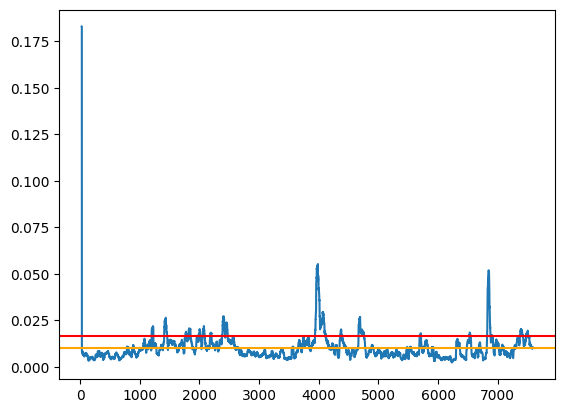

In [17]:


def ma_signal(df, **kwargs):
    
    short_period = get_attr(kwargs, 'short_period', 10)
    long_period = get_attr(kwargs, 'long_period', 20)

    df['signal'] = df['adjclose'].rolling(short_period).mean() - df['adjclose'].rolling(long_period).mean()
    df['signal+1'] = df['signal'].shift(1)
    df = df.dropna()

    return df



df = spy_df.copy()
df['signal'] = df['adjclose'].rolling(10).mean() - df['adjclose'].rolling(20).mean()
df['signal+1'] = df['signal'].shift(1)
df['returns'] = np.insert(df['close'].to_numpy()[1:] / df['close'].to_numpy()[:-1], 1, 0) - 1
df['volatility'] = df['returns'].rolling(30).std()

df



# print(env.records['portfolio_volatility'])

In [19]:
from environments.gym_env import TradingEnv
input_feature_list = [
    'open',
    'high',
    'low',
    'close',
    'adjclose',
    'signal',
    'signal+1',
    'volume',
    'volatility'
]
env = TradingEnv(df=df, input_feature_list=input_feature_list)

c:\Users\alexr\miniconda3\envs\TradeMaster\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float64
  logger.warn(


In [18]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        '''
        Save a transition
        '''
        self.memory.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [7]:
class DQN(nn.Module):
    
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    

In [8]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-5

# n_actions = env.action_space.shape[0]
n_actions = 10
state = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            action = policy_net(state)
    else:
        action = torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
    
    
    return action.view(1, 2)

episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())

    # plot 100 episode averages
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        # means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    
    plt.pause(0.001)

    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())



In [9]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    print(non_final_next_states)
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch)

    # Compute V(S_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        # next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
        next_state_values = target_net(non_final_next_states)
    print(next_state_values)
    # Compute expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


In [10]:
torch.autograd.detect_anomaly()

if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 1

for i_episode in range(num_episodes):
    print(f'episode:{i_episode}')
    # initialise env
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():
        # print(f'steps: {t}')
        action = select_action(state)
        np_action = action.detach().numpy()[0]
        observation, reward, terminated, _ = env.step(np_action)
        reward = torch.tensor([reward], device=device)
        done = terminated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # store the transition in memory
        memory.push(state, action, next_state, reward)

        # move to next state
        state = next_state

        # perform one step of the optimisation (on the policy network)
        optimize_model()

        # soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()

        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        

print('complete')

plt.ioff()
plt.show()

C:\Users\alexr\AppData\Local\Temp\ipykernel_5656\2007504657.py:1: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  torch.autograd.detect_anomaly()
C:\Users\alexr\AppData\Local\Temp\ipykernel_5656\4173370144.py:41: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  action = torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
C:\Users\alexr\AppData\Local\Temp\ipykernel_5656\4173370144.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:204.)
  action = torch.tensor([[env.action_space.sample()]], device=device, dtype=torch

episode:0
tensor([[ 4.0829e+02, -6.7225e-01, -1.9218e+00,  ...,         nan,
                 nan,         nan],
        [ 4.0537e+02,  7.4444e+00,  7.8151e+00,  ...,         nan,
                 nan,         nan],
        [ 4.0493e+02,  2.2277e+00,  2.3543e+00,  ...,         nan,
                 nan,         nan],
        ...,
        [ 3.7052e+02,  1.1546e+00,  1.4926e+00,  ...,  3.2514e+11,
         -2.6827e+00,  8.4235e+04],
        [ 3.7537e+02, -2.6900e-01,  7.9095e-01,  ..., -2.2266e+21,
         -3.1321e-09,  7.9504e+14],
        [ 3.5467e+02,  3.2664e+00,  4.1570e+00,  ...,  1.1223e+11,
         -2.4347e+00,  4.4704e+04]])
tensor([[       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [1.3454e+11, 2.4837e+10],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan],
        [2.7752e+20, 1.2252e+19],
        [       na

RuntimeError: The size of tensor a (2) must match the size of tensor b (128) at non-singleton dimension 1

In [ ]:
state = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
print(state)
terminated = False
while not terminated:
    # print(f'steps: {t}')
    action = policy_net(state).view(1, 2)
    np_action = action.detach().numpy()[0]
    print(np_action)
    observation, reward, terminated, _ = env.step(np_action)
    reward = torch.tensor([reward], device=device)

    print(env.records)

    next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

    # # store the transition in memory
    # memory.push(state, action, next_state, reward)

    # # move to next state
    # state = next_state

    # # perform one step of the optimisation (on the policy network)
    # optimize_model()

    # # soft update of the target network's weights
    # # θ′ ← τ θ + (1 −τ )θ′
    # target_net_state_dict = target_net.state_dict()
    # policy_net_state_dict = policy_net.state_dict()

    # for key in policy_net_state_dict:
    #     target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
    # target_net.load_state_dict(target_net_state_dict)





tensor([[3.4565e+02, 8.9894e+00, 9.5827e+00, 1.0000e+06, 0.0000e+00, 0.0000e+00,
         1.0000e+06, 0.0000e+00, 0.0000e+00]])
[nan nan]
{'cash': [nan], 'position': [nan], 'position_value': [nan], 'portfolio_value': [nan], 'leverage': [nan], 'portfolio_volatility': [nan], 'portfolio_return': [nan]}
[nan nan]
{'cash': [nan, nan], 'position': [nan, nan], 'position_value': [nan, nan], 'portfolio_value': [nan, nan], 'leverage': [nan, nan], 'portfolio_volatility': [nan, nan], 'portfolio_return': [nan, nan]}
[nan nan]
{'cash': [nan, nan, nan], 'position': [nan, nan, nan], 'position_value': [nan, nan, nan], 'portfolio_value': [nan, nan, nan], 'leverage': [nan, nan, nan], 'portfolio_volatility': [nan, nan, nan], 'portfolio_return': [nan, nan, nan]}
[nan nan]
{'cash': [nan, nan, nan, nan], 'position': [nan, nan, nan, nan], 'position_value': [nan, nan, nan, nan], 'portfolio_value': [nan, nan, nan, nan], 'leverage': [nan, nan, nan, nan], 'portfolio_volatility': [nan, nan, nan, nan], 'portfolio_r

In [ ]:
a = torch.tensor([[[       376, -172506561]]])
print(a)
print(a.view(1, 2))
b = torch.tensor([[20260.3945],[ 8213.6328]])
print(b.view(1, 2))

tensor([[[       376, -172506561]]])
tensor([[       376, -172506561]])
tensor([[20260.3945,  8213.6328]])
